# Tutorial on calculating the band structure for Si

In [2]:
import os
import sys
import re
from mp_api.client import MPRester
from siman import header
from siman.SSHTools import SSHTools
from siman.header import _update_configuration, db
from siman.calc_manage import smart_structure_read
from siman.database import read_database, write_database
import project_sets
from siman.set_functions import read_vasp_sets
from siman.electronic.band_structure.plot_bands import plot_bands
from siman.electronic.band_structure import band_structure as bs
from siman.wrappers import waiting_calc_complete as wrap
from siman.wrappers import sets_wrap as swrap

In [3]:
_update_configuration('simanrc.py') # simanrc.py should be in the folder with project 
read_database() # read database if exist
api_key = '***' # your api-key
PATH2AFLOW = "/Users/irinabrodyagina/src/AFLOW/aflow.3.2.14/aflow" # path to AFLOW in you local machine

In [5]:
# Defining the basic parameters for calculations

sp_pack = {'KSPACING': 0.33, 'NPAR':None,'ISTART':None,'NELM':None,'PREC':None,'ALGO':None,
           'KGAMMA':None,'ENCUT':600,'LPLANE':None, 'LREAL':'.FALSE.',
           'EDIFF': 1.e-8}

band_pack = {'LORBIT': 11, 'ICHARG': 11}



**1 Step. Define the structure**

You can use a ready-made POSCAR file or read the structure from MP and create the POSCAR yourself

In [6]:
silicon = ['mp-149']

with MPRester(api_key) as mpr:
    docs = mpr.materials.summary.search(
        material_ids=silicon
    )

for doc in docs:
    st = doc.structure
    st_name = re.sub(r'([()\\[\]])', r'', st.reduced_formula)

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
folder_name = os.getcwd() #folder with your project
path_to_POSCAR, path_to_main_folder = bs.create_POSCAR(st, st_name, home_path=folder_name, debug=True)



From create_POSCAR: the file /Users/irinabrodyagina/PycharmProjects/find_k-path/Si/Si.POSCAR was crested


**2 Step. Perform single-point calculation**

In [20]:
# Create set with parametres
varset = read_vasp_sets(project_sets.user_vasp_sets, override_global=0)
swrap.create_new_set("sp", "static", sp_pack)


Attention! You have chosen to override set sp
 



In [21]:
# Calculations
siman_st = smart_structure_read(path_to_POSCAR)
wrap.charge_calc(st_name, siman_st, 'sp')

-- Attention!, cluster None is not found, using default ccmm 

-- Warning! This calculation was already submitted. Use run = 2 to submit it again 

-- Warning! run = 2, the calculation is resubmitted 

--                           |  energy(eV)|    Vector lenghts (A)   | Stresses (MPa)     | N MD, N SCF    
-- db['Si.sp.1']                 |  -10.8407  |3.87, 3.87, 3.87|    -25,-25,-25     |   1,14, 14    

Database has been successfully updated

-- check_kpoints(): Kpoint   mesh is:  [7, 7, 7] 

-- check_kpoints(): The actual k-spacings are  ['0.29', '0.29', '0.29'] 

-- POSCAR was written to Si//Si.sp/1.POSCAR 

-- Attention! ngkpt =  [7, 7, 7]  is adopted from struct_des which you provided for it  Si  and kspacing =  0.33 


Calculation db[('Si', 'sp', 1)] successfully created

 

JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
Submitted batch job 31428
             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
             31428    

**3 Step. Finding the k-path and non-self-consistent calculation**

In [27]:
# Finding the highly symmetric k-path with AFLOW. For it you have to identify PATH2AFLOW
# Also you can use method='seekpath'

k_path_band = bs.find_kpath(st=st, method="AFLOW", path_to_POSCAR=path_to_POSCAR, debug=True)



From find_kpath: generated k_path is

 [128, ('G', 0.0, 0.0, 0.0), ('X', 0.5, 0.0, 0.5), ('W', 0.5, 0.25, 0.75), ('K', 0.375, 0.375, 0.75), ('G', 0.0, 0.0, 0.0), ('L', 0.5, 0.5, 0.5), ('U', 0.625, 0.25, 0.625), ('W', 0.5, 0.25, 0.75), ('L', 0.5, 0.5, 0.5), ('K', 0.375, 0.375, 0.75), ('U', 0.625, 0.25, 0.625), ('X', 0.5, 0.0, 0.5)]


In [28]:
# Creating the new set

swrap.create_new_set("band_structure", "sp", band_pack, k_path=k_path_band, path_key='k_band_structure', debug=True)



From create_new_set: the k-path was added in parameters of new set

Attention! You have chosen to override set band_structure
 

-- s.params['EDIFF']              = 1e-08  
-- s.params['NSW']                = 0  
-- s.params['ENCUT']              = 600  
-- s.params['ENAUG']              = 700.0  
-- s.params['KSPACING']           = 0.33  
-- s.params['LREAL']              = .FALSE.  
-- s.params['ISMEAR']             = 0  
-- s.params['SIGMA']              = 0.1  
-- s.params['mul_nbands_small_cell'] = 3  
-- s.params['ICHARG']             = 11  
-- s.params['LORBIT']             = 11  
-- ngkpt: None 

-- POTDIR: {300: 'void', 200: 'octa', 0: 'n', 1: 'H', 2: 'He', 3: 'Li', 4: 'Be', 5: 'B', 6: 'C', 7: 'N', 8: 'O', 9: 'F', 10: 'Ne', 11: 'Na', 12: 'Mg', 13: 'Al', 14: 'Si', 15: 'P', 16: 'S', 17: 'Cl', 18: 'Ar', 19: 'K', 20: 'Ca', 21: 'Sc', 22: 'Ti', 23: 'V', 24: 'Cr', 25: 'Mn', 26: 'Fe', 27: 'Co', 28: 'Ni', 29: 'Cu', 30: 'Zn', 31: 'Ga', 32: 'Ge', 33: 'As', 34: 'Se', 35: 'Br', 36: 'Kr',

In [29]:
# Non-self-consistent calculation

wrap.non_self_consist_calc(st_name, 'band_structure', 'sp', path_to_POSCAR=path_to_POSCAR)

-- Attention!, cluster None is not found, using default ccmm 

-- Directory .//Si/Si.if  was created 

-- File xyz/Si.sp.1.end.xyz was written 

-- inherit_ngkpt(): the k-grid from Si was inherited to Si.if 

-- Warning! This calculation was already submitted. Use run = 2 to submit it again 

-- Warning! run = 2, the calculation is resubmitted 

-- Directory Si//Si.if.band_structure  was created 

--                           |  energy(eV)|    Vector lenghts (A)   | Stresses (MPa)     | N MD, N SCF    
-- db['Si.if.band_structure.1']  |  -11.4238  |3.87, 3.87, 3.87| -2596,-2596,-2596  |   1, 7,  7    

Database has been successfully updated

-- check_kpoints(): Kpoint   mesh is:  [7, 7, 7] 

-- check_kpoints(): The actual k-spacings are  ['0.29', '0.29', '0.29'] 

-- POSCAR was written to Si//Si.if.band_structure/1.POSCAR 

-- Writing k-points file for band structure calculation. 


Calculation db[('Si.if', 'band_structure', 1)] successfully created

 

-- Copying CHGCAR for band struc

**4 Step. Plotting the band structure**

In [11]:
# You can build the total or orbital projected band structure for particular element. 
# For it just change the parameter mode='total'/'projected', for 'projected' you also have to identify the element
# Also you have to provide paths to the KPOINTS file, which you used for non-self-consistent calc, and to output vasprun.xml file 

band_set_name = "band_structure"
band_file_name = st_name + '.if'
vasprun_path = f'{st_name}/{band_file_name}.{band_set_name}/1.vasprun.xml'
kpoints_file_path = f'{st_name}/{band_file_name}.{band_set_name}/KPOINTS'

# You will have the same paths to files, if you have used the functions above

# In addition, you can add the name of the method for k-path determination (in the title) and change the limits on the y-axis

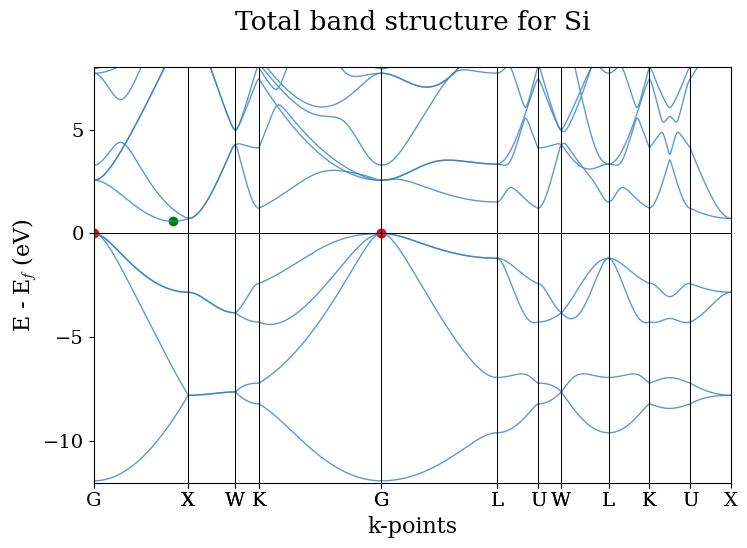

In [36]:
plot_bands(st_name, vasprun_path=vasprun_path,
           kpoints_file_path=kpoints_file_path,
           ylim=(-12, 8), method="AFLOW", vbm_cbm_marker=True, debug=True, mode='total')

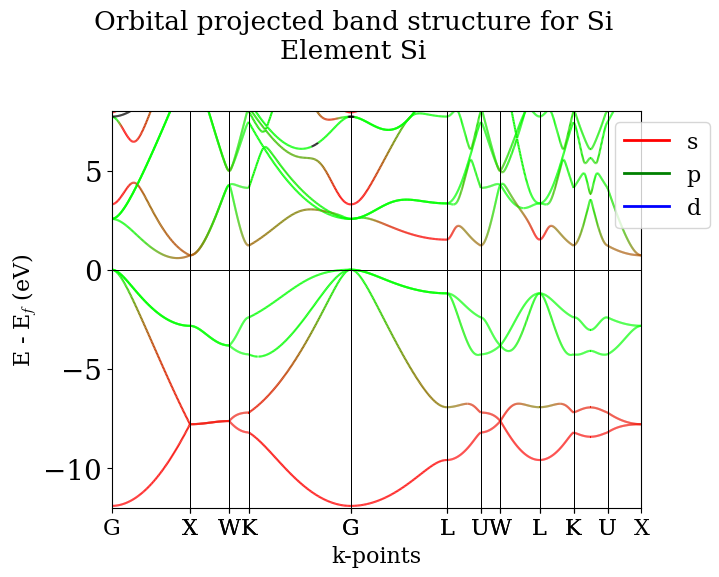

In [10]:
plot_bands(st_name, vasprun_path=f'{st_name}/{band_file_name}.{band_set_name}/1.vasprun.xml',
           kpoints_file_path=f'{st_name}/{band_file_name}.{band_set_name}/KPOINTS',
           ylim=(-12, 8), method="", vbm_cbm_marker=True, debug=True, mode='projected', element='Si')

# Old version: 

**In this lesson we calculate and plot both band structure and dos for Bi2Se3**

In [1]:
from siman import header
from siman.SSHTools import SSHTools
from siman.calc_manage import add_loop, res_loop
from siman.database import write_database, read_database
from siman.set_functions import read_vasp_sets
from siman.dos_functions import plot_dos
from siman.bands import plot_bands
%matplotlib inline
read_database() # read database if exist
header.PATH2PROJECT    = 'topologic' # path to project relative to your home folder on cluster
header.PATH2POTENTIALS = '/home/aksenov/scientific_projects/PAW_PBE_VASP' #path to VASP POTENTIALS
header.varset['static'].potdir = {83:'Bi_pv', 34:'Se'} #subfolders with required potentials
header.ssh_object = SSHTools()
header.ssh_object.setup(user="aksenov",host="10.30.16.62",pkey="/home/aksenov/.ssh/id_rsa")

/home/aksenov/simanrc.py was read


In [2]:
#Creating new sets for DOS and Bands
dos_pack = {'NSW':0, 'LORBIT':11, 
            'ISMEAR':-5, 'LAECHG':'.TRUE.', 
            'EMIN':-10, 'EMAX':14, 
            'NEDOS':2000, 'KSPACING':0.15, 
            'savefile':'d'}
read_vasp_sets([('dos', 'static',dos_pack, 'override')]) #new set 'dos' from 'static'

band_pack = {'ICHARG':11, 'LORBIT':11, 
             'k_band_structure':[40, ('G', 0, 0, 0), ('Z', 0.5, 0.5, 0.5), 
                                 ('F', 0.5, 0.5, 0), ('G', 0, 0, 0), ('L', 0, 0.5, 0)]
}
read_vasp_sets([('band', 'static', band_pack, 'override')]) #new set 'band' from static


Attention! You have chosen to override set dos
 

Warning! You did not change  NSW  in dos set
 


Attention! You have chosen to override set band
 



{'static': <set_functions.InputSet at 0x7ffba5803828>,
 'band': <set_functions.InputSet at 0x7ffba5814470>,
 'dos': <set_functions.InputSet at 0x7ffba2ed4f28>}

In [4]:
#calculate charge density
add_loop('Bi2Se3.rho', 'static', 1, input_geo_file = 'in/Bi2Se3_mp-541837_computed.POSCAR', it_folder = 'Bi2Se3', run = 0)


command: pwd
-- You provided the following geo file explicitly  in/Bi2Se3_mp-541837_computed.POSCAR ; Version of file does not matter, I use *curver*= 1 as a new version 

-- check_kpoints(): Kpoint   mesh is:  [8, 8, 8] 

-- check_kpoints(): The actual k-spacings are  [ 0.22  0.22  0.22] 

-- Attention! ngkpt =  [8, 8, 8]  is adopted from struct_des which you provided for it  Bi2Se3.rho  and kspacing =  0.235 

command:  mkdir -p /home/aksenov/topologic/Bi2Se3//Bi2Se3.rho.static/
command: chmod +x /home/aksenov/topologic/Bi2Se3//Bi2Se3.rho.static/Bi2Se3.rho.static.run

Calculation ('Bi2Se3.rho', 'static', 1) successfully created

 



'Bi2Se3.rho'

In [5]:
res_loop('Bi2Se3.rho', 'static', 1)

-- name                          |  energy(eV)|    Vector lenghts (A)   | Stresses (MPa)     | N MD, N SCF    
-- Bi2Se3.rho.static.1           |  -20.1543  |    10.27;10.27;10.27    |  -680,-680,-657    |   1,13, 13    


(['Bi2Se3.rho.static.1           |  -20.1543  |    10.27;10.27;10.27    |  -680,-680,-657    |   1,13, 13   '],
 [])

In [3]:
#inherit charge density and make non-selfconsistent calculation of band structure
add_loop('Bi2Se3.rho', 'static', 1, ise_new = 'band', inherit_option = 'full', savefile = 'ocx', override = 1, run = 1)

-- Warning! File ./Bi2Se3/Bi2Se3.rho.if/Bi2Se3.rho.if.inherit.full.1.geo was replaced 

-- File xyz/Bi2Se3.rho.static.1.end.xyz was written 

-- inherit_ngkpt(): the k-grid from Bi2Se3.rho was inherited to Bi2Se3.rho.if 

-- check_kpoints(): Kpoint   mesh is:  [8, 8, 8] 

-- check_kpoints(): The actual k-spacings are  [ 0.22  0.22  0.22] 

-- Writing k-points file for band structure calculation. 


Calculation ('Bi2Se3.rho.if', 'band', 1) successfully created

 

-- Coping CHGCAR for band structure 

-- cp /home/aksenov/topologic/Bi2Se3//Bi2Se3.rho.static/1.CHGCAR.gz /home/aksenov/topologic/Bi2Se3//Bi2Se3.rho.if.band///CHGCAR.gz; gunzip -f /home/aksenov/topologic/Bi2Se3//Bi2Se3.rho.if.band///CHGCAR.gz 

Submitted batch job 78109
             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
             78109       AMG Bi2Se3.r  aksenov PD       0:00      1 (None) 

-- To read results use  res_loop('Bi2Se3.rho.if', ['band'], [1], show = 'fo'  )     # , on 2016-12-

'Bi2Se3.rho.if'

In [4]:
#calculate dos
add_loop('Bi2Se3.rho', 'dos', 1, savefile = 'ocx', input_geo_file = 'Bi2Se3_mp-541837_computed.POSCAR', it_folder = 'Bi2Se3', run = 1)

-- You provided the following geo file explicitly  Bi2Se3_mp-541837_computed.POSCAR ; Version of file does not matter, I use *curver*= 1 as a new version 

-- check_kpoints(): Kpoint   mesh is:  [12, 12, 12] 

-- check_kpoints(): The actual k-spacings are  [ 0.15  0.15  0.15] 

-- Attention! ngkpt =  [12, 12, 12]  is adopted from struct_des which you provided for it  Bi2Se3.rho  and kspacing =  0.15 


Calculation ('Bi2Se3.rho', 'dos', 1) successfully created

 

Submitted batch job 78110
             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
             78110       AMG Bi2Se3.r  aksenov PD       0:00      1 (None)
             78109       AMG Bi2Se3.r  aksenov  R       0:09      1 node-amg01 

-- To read results use  res_loop('Bi2Se3.rho', ['dos'], [1], show = 'fo'  )     # , on 2016-12-13   ; possible options for show: fit, fo, fop, en, mag, magp, smag, maga, occ, occ1, mep, mepp 



'Bi2Se3.rho'

In [13]:
#read results, download xml files
res_loop('Bi2Se3.rho.if', 'band', 1,  up = 'x')
res_loop('Bi2Se3.rho',    'dos',  1,  up = 'x')

-- name                          |  energy(eV)|    Vector lenghts (A)   | Stresses (MPa)     | N MD, N SCF    
-- Bi2Se3.rho.if.band.1          |  -12.1562  |    10.27;10.27;10.27    | 21327,21908,1574   |   1,11, 11    
-- name                          |  energy(eV)|    Vector lenghts (A)   | Stresses (MPa)     | N MD, N SCF    
-- Bi2Se3.rho.dos.1              |  -20.1559  |    10.27;10.27;10.27    |  -687,-688,-649    |   1,13, 13    


(['Bi2Se3.rho.dos.1              |  -20.1559  |    10.27;10.27;10.27    |  -687,-688,-649    |   1,13, 13   '],
 [])

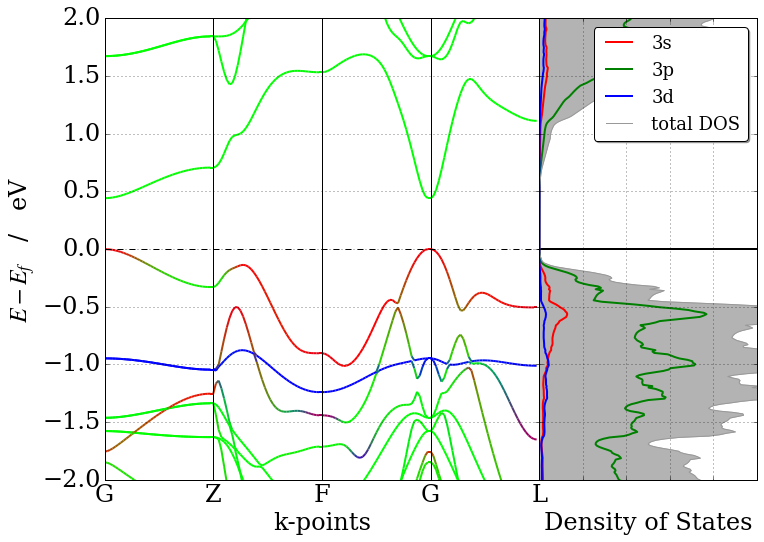

In [12]:
#plot bands and dos using xml files
plot_bands(vasprun_dos   = 'Bi2Se3/Bi2Se3.rho.dos/1.vasprun.xml', 
           vasprun_bands = 'Bi2Se3/Bi2Se3.rho.if.band/1.vasprun.xml',
           kpoints       = 'Bi2Se3/Bi2Se3.rho.if.band/KPOINTS',
           element = 'Bi',
           ylim = (-2,2))